In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
MOVIE_DIR="./images"

CREATE_MOVIE = False # True if you have ffmpeg installed

import training_models_helper
%aimport training_models_helper

tmh = training_models_helper.TrainingModelsHelper()

import mnist_helper
%aimport mnist_helper

mnh = mnist_helper.MNIST_Helper()

import class_helper
%aimport class_helper

clh= class_helper.Classification_Helper()

import recipe_helper
%aimport recipe_helper
rh = recipe_helper.Recipe_Helper()

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Becoming a successful Data Scientist: Error Analysis

As of now, you should know
- how to construct models (the "recipe")
- how to use them for prediction
- some simple metrics on how they perform

In this module, the topics to be covered provide answers:
- model diagnostics 

In other words: the importance of Error Aanalysis in diagnosing and improving models.

# Classification: Beyond accuracy

Let's re-run the MNIST problem and examine measures of error more detailed than accuracy


In [5]:
mnh = mnist_helper.MNIST_Helper()
mnh.setup()
_= mnh.fit()

Retrieving MNIST_784 from cache


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.1, verbose=0,
                   warm_start=False)

Examine the score (n.b., ran with L2 penalty)

In [6]:
clf = mnh.clf

 # Cross validation
scores = cross_val_score(clf, mnh.X_train, mnh.y_train, cv=10)
print("Avg cross val score={s:3.2f}\n".format( s=scores.mean()) )

# How many zero coefficients were forced by the penalty ?
sparsity = np.mean(clf.coef_ == 0) * 100

print("Sparsity with {p} penalty: {s:.2f}.".format(p=clf.penalty, s=sparsity) )

Avg cross val score=0.87

Sparsity with l2 penalty: 16.20.


We achieved an out of sample accuracy of about 87%

That sounds good, but is it really ?

If each of the 10 labels occurs with equal frequency among the training examples
- We could mis-predict *every* occurrence of a single digit(i.e., 10% of the training examples)
- And still achieve an Accuracy of 90% if we perfectly predict all other digits

Would that be satisfactory ?

This motivates the need to measure *Conditional Performance* or *Conditional Loss*
- Performance/Loss conditioned on meaningful subsets of training examples

We will examine some conditional metrics for the Classification task.

<img src="images/Back_to_parent.jpg">

# Binary classification: Conditional accuracy

For simplicity: let's begin with a Classification task with only two classes (Positive and Negative).

We can divide overall Accuracy into 4 subsets:

- the row labels correspond to the predicted class
- the column labels correspond to the target (actual) class

$$
\begin{array}{lll}
\\
           & \textbf{P} &  \textbf{N} \\
\textbf{P} & \text{TP}        & \text{FP} \\
\textbf{N} & \text{FN}        & \text{TN} \\
\end{array}
$$

The correct predictions
- True Positives (TP) are  test examples predicted as Positive that were in fact Positive
- True Positives (TN) are  test examples predicted as Negative that were in fact Negative

The incorrect predictions
- False Positives (FP) are  test examples predicted as Positive that were in fact Negative
- False Positives (FN) are  test examples predicted as Negative that were in fact Positive


Unconditional Accuracy can thus be written as

$$\textrm{Accuracy} =  { \text{TP} + \text{TN} \over  \text{TP} + \text{FP} + \text{TN} + \text{FN} } $$

We can also define some conditional Accuracy measures

## Imbalanced data: the case for conditional accuracy

It is quite possible that the number of Positive and Negative examples in a dataset are quite different
- Titanic example: many fewer examples with Survive than Not Survive

Metrics based on unconditional accuracy favor the dominant category (the one with most examples).
- They are more numerous and hence have greater cumulative influence
$$\text{TP} + \text{FN} << \text{TN} + \text{FP}$$

Conditional metrics are one way of placing focus on the minority category.

##  Recall
- Conditioned on Positive test examples

$$
\textrm{Recall} = { { \textrm{TP} } \over { \textrm{TP} +  \textrm{FN} }  }
$$
- The fraction of Positive examples that were correctly classified
- You can achieve 100% Recall by always predicting positive, but Unconditional Accuracy will suffer.
- Also goes by the names: True Positive Rate (TPR), Sensitivity

## Specificity
- conditioned on Negative examples

$$
\textrm{Specificity} = { { \textrm{TN} } \over { \textrm{TN} +  \textrm{FP} }  }
$$

- The fraction of Negative examples that were correctly classified
- Also goes by the name: True Negative Rate (TNR)

## Precision
A metric to tell you the fraction of your Positive predictions that were correct.

$$
\textrm{Precision} = { { \textrm{TP} } \over { \textrm{TP} +  \textrm{FP} }  }
$$

There is a degenerate case of perfect precision:
- predict "Positive" for only a single, known actual positive
- 100% precision, but you fail to correctly predict most actual positives

## False Positive Rate
$$
\begin{array}{lll}
\textrm{FPR} & = & { { \textrm{FP} } \over { \textrm{FP} + \textrm{TN} } } \\
             & = & 1 - \textrm{Specificity}
\end{array}
$$

<img src="images/Back_to_parent.jpg">

## Precison/Recall Tradeoff

Ideally, we would like our model to have both
- High Recall: correctly identify a large fraction of Positive examples
- High Precision: do not mis-identify too many Negative examples as positive

But it may not be possible to have both.

We will 
- show how to trade off one measure for the other
- discuss when to favor one type of error over another


Some Classification models (e.g., Logistic Regression) have hyperparameters
that compare numerical "scores" to a threshold in order to make a prediction.

By varying the threshold, we can change predictions to favor a particular Conditional Performance metric.

We will show how this happens and demonstrate ways to evaluate the tradeoff between metrics.

Recall our methodology for Classification via Logistic Regression:
- Compute a "score" that our example is in each of the target classes
- Construct a probability distribution (over the target classes) from the scores
    - convert the per class score into a probability via the sigmoid/softmax function
- Compare the probability to a threshhold

$$\hat{p} = \sigma(\Theta^T \x)  $$
where $\sigma$,  the *logistic function*, is:

Convert $\hat{p}^\ip$ into Classification prediction $\hat{y}^\ip$

$$
\hat{y}^\ip = 
\left\{
    {
    \begin{array}{lll}
    0 & \textrm{if } \hat{p}^\ip < 0.5   & \text{Negative} \\
    1 & \textrm{if } \hat{p}^\ip \ge 0.5  & \text{Positive} \\
    \end{array}
    }
\right.
$$

<table>
    <tr>
        <center>Separation bounday as function of probability threshold</center>
    </tr>
<img src="images/class_overview_prob_lines.jpg" width=1000>
</table>


We can affect the prediction of Positive/Negative by varying the choice of Threshhold.

We can increase the number of Positive predictions by lowering the threshhold
- this will increase TP
    - increase Recall by increasing numerator
    - degenerate case: *always* predict Positive !
- but also increase  FP
    - no effect on Recall (FP *does not* appear in denominator)
    - which decreases Precision (where FP *does* appear in the denominator)
    
So there is a tradeoff between Recall and Precision that is determine by our choice of threshold.

**Precision vs Recall: which one to favor ?**

- Depending on the context, you may favor Precision over Recall, or vice-versa:
    - Favor Precision when a False Positive is undesirable
        - FP: mistakenly tell someone they are in trouble
    - Favor Recall when False Negative is undesirable
        - FN: mistakenly fail to identify a highly-communicable disease

Why would we want to increase Recall (at the potential cost of decreased unconditional Accuracy) ?

It depends on your task.

Consider a diagnostic test for an extremely dangerous, infectious disease
- It might very important to have high Recall (catch truly infected patients)
- Even at the expense of incorrectly labelling some healthy patients as infected

By *decreasing* the threshold we increase the number of Positive predictions
- Recall increases (by increasing TP)
- Precision decreases (by increasing FP)


By *raising* the threshhold, we can decrease the number of Positive predictions.
- Potentially decrease Recall (by decreasing TP)
- Increase Precision (by decreasing FP)

Decreasing the number of Positive predictions increases the number of Negatives
- Complementary effect on the Negative counterparts of the Positive metrics (Recall:Specificity)
- Increase Specificity (by decreasing FP, we increase TN)

Why would we want to increase Specificity (potentially decreasing unconditional Accuracy) ?
- decrease Unconditional Accuracy by increasing the False Negatives (FN)

Consider a diagnostic test for a mild, non-infectious disease
- A Positive prediction might entail an expensive/painful remedy, which we want to avoid
- Even at the expense of incorrectly labelling some non-healthy patients as healthy
   

### Precision/Recall tradeoff: plot

To be concrete: let's examine the tradeoff between Recall and Precision
in the context of a binary classifier
- Using MNIST examples: classify an example as being a single chosen digit versus the 9 other digits

- Create a binary classifier for a single MNIST digit

In [7]:
# Fetch the MNIST data into object

mnh_d = mnist_helper.MNIST_Helper()
mnh_d.setup()

# Turn the 10 class training set into a binary training set
# - Same examples, different targets
# - targets are now "is 'digit'" or "is not 'digit'" for a single digit
digit = '5'
y_train_d, y_test_d = mnh_d.make_binary(digit)

# Fit a binary model: Is digit/Is not digit
mnh_d.fit(y_train=y_train_d)
scores = cross_val_score(mnh_d.clf, mnh_d.X_train, y_train_d, cv=3, scoring="accuracy")

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(mnh_d.clf, mnh_d.X_train, y_train_d, cv=5, method="decision_function")


Retrieving MNIST_784 from cache


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.1, verbose=0,
                   warm_start=False)

Let's plot the tradeoff

In [8]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_d, y_train_pred)

# Convert thresholds (log odds) to probability
probs = np.exp(thresholds)/(1+np.exp(thresholds))

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, probs=None):
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    
    if probs is None:
        horiz = thresholds
        label = "Threshold"
    else:
        horiz = probs
        label = "Probability threshold"
    _ = ax.plot(horiz, precisions[:-1], "b--", label="Precision", linewidth=2)
    _ = ax.plot(horiz, recalls[:-1], "g-", label="Recall", linewidth=2)
    _ = ax.set_xlabel(label, fontsize=16)
    _ = ax.legend(loc="upper left", fontsize=16)
    _ = ax.set_ylim([0, 1])
    
    _ = ax.set_xlim([ horiz.min(), horiz.max()])
    
    return fig, ax

fig, ax = plot_precision_recall_vs_threshold(precisions, recalls, thresholds, probs=probs)
plt.close(fig)

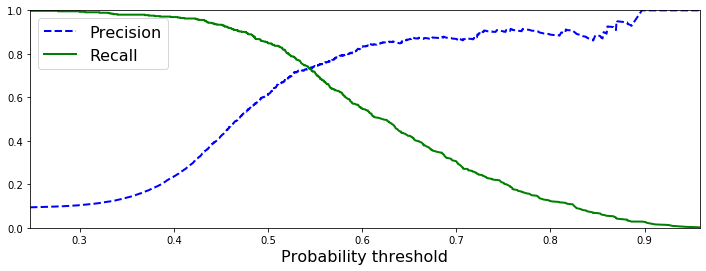

In [9]:
fig

You can see how varying the threshold (units is log odds ?) affects Recall and Precision
- one at the expense of the other

### ROC/AUC: Evaluating the Precision/Recall tradeoff

The **ROC** plots the True Positive Rate (TPR) versus the False Positive Rate (FPR).

The resulting curve helps us choose a threshold.

Our goal is to get a high TPR with a low FPR.

This corresponds to the Area Under the Curve being as high as possible, as we will see in the plots.

Here's how it works
- fit a binary classifier
- predict on a dataset (e.g., test)
    - this gives a vector of probabilities for each example
    - classifier predicts Positive if corresponding probability exceeds a threshold
- vary the threshold between 0 and 1
    - each threshold value gives a TPR and FPR

We illustrate with a couple of classifiers for the binary MNIST digit classification problem.

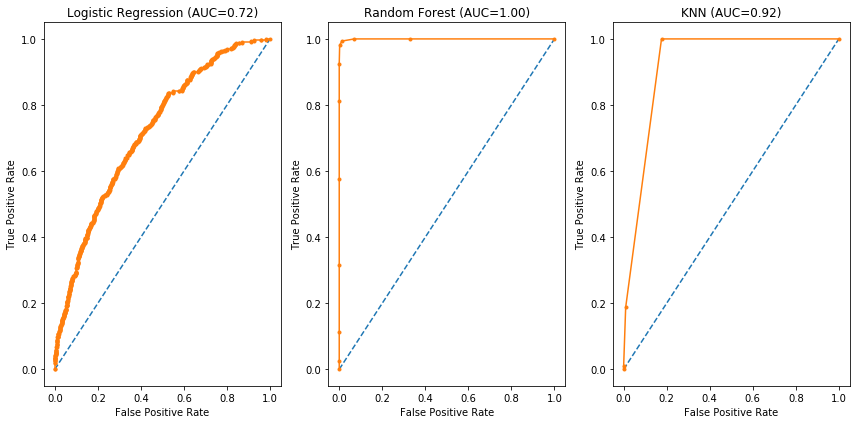

In [10]:
# ROC curves for binary classifier: Is Digit/Is not Digit
clh.AUC_plot(X_train=mnh.X_train, y_train=y_train_d, X_test=mnh.X_train, y_test=y_train_d)


You can see the results of 
- Logistic Regression
- KNN
- Random Forests

### $F_1$: Another way to combine Precision and Recall

There is a simple metric to combine
 Precision and Recall into a single number:

$$
\textrm{F}_1 = { { \textrm{TP} } \over { \textrm{TP} +  { { \textrm{FN} + \textrm{FP} }   \over 2 } }  }
$$

<img src="images/Back_to_parent.jpg">

# Multinomial classification: Confusion matrix

So far we have been dealing with a classifier with only two classes.

So the simple grid

$$
\begin{array}{lll}
\\
           & \textbf{P} &  \textbf{N} \\
\textbf{P} & \text{TP}        & \text{FP} \\
\textbf{N} & \text{FN}        & \text{TN} \\
\end{array}
$$

was sufficient.

The generalization of the  multiple classes is called the *Confusion Matrix*

Normalized confusion matrix


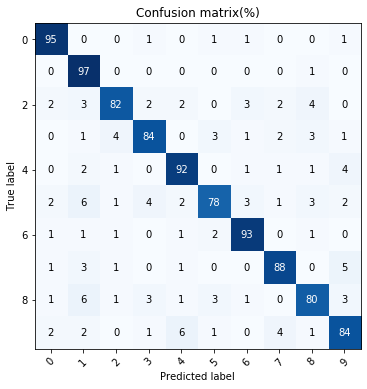

In [11]:
# Now predict the value of the digit on the second half:
fig, ax = plt.subplots(figsize=(12,6))
confusion_mat = mnh.create_confusion_matrix()

digits = range(0,10)
_= clh.plot_confusion_matrix(confusion_mat, digits, ax=ax, normalize=True)

- The row labels are the (correct) targets
- The column labels are the predictions

The entry in the matrix for row $i$, column $j$
- fraction of test examples for class $i$ that were
predicted as class $j$.

- The diagonal of the Confusion Matrix is the Recall for each digit
- The non-diagonal elements of a row show how often a given digit was mistaken for another

By analyzing the non-diagnonal elements of a row, we may be able to diagnose (and correct) defficiencies in our model.

From the confusion matrix: 
- our classifier is doing a great job recognizing the digit 0
- our classifier is struggling to recognize the digit 5
    - most often confusing it with the digit 3
- our classifier is struggling to recognize the digit 8
    - most often confusing it with the digits 5 and 1


<img src="images/Back_to_parent.jpg">

## Regression: beyond RMSE/$R^2$

We just spent time developing methods to study errors of classification.

What is the analog for Regression ?

Examining the residuals.

Coefficients: 
 [9.86448852] [[0.93673892]]


R-squared (test): 0.91
Root Mean squared error (test): 13.73


R-squared (train): 0.91
Root Mean squared error (train): 13.13


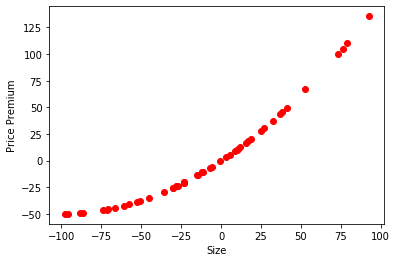

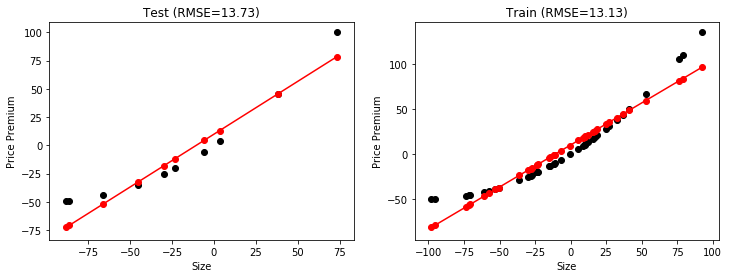

In [12]:
v1, a1 = 1, .005
v2, a2 = v1, a1*2
curv = recipe_helper.Recipe_Helper(v = v2, a = a2)
X_curve, y_curve = curv.gen_data(num=50)

(xlabel, ylabel) = ("Size", "Price Premium")

figp, axp = curv.gen_plot(X_curve,y_curve, xlabel, ylabel)

fig, axs = curv.regress_with_error(X_curve, y_curve, xlabel=xlabel, ylabel=ylabel)
plt.close(fig)

Let's focus on the errors.

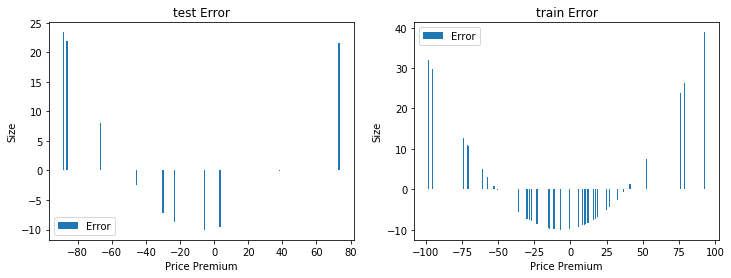

In [13]:
fig

Not good !
- clear pattern: errors increase in the tails
- not constant variance

Recall that our conclusion was that there was a missing feature: a higher order $x^2$ term.

Once we added that term, the target became linear in 
$$ \Theta^T \cdot X = \beta_1 *x + \beta_2 * x^2$$

In [14]:
print("Done")

Done
